# Introduction to model fitting

### Goals:

1. To understand what it means to fit a model, and to derive estimates for the values on the parameters in the model.
2. To fit a linear model for the time variation of the flux of the Vela pulsar to the data.
3. To use the results of that fit to decide if the flux of the Vela pulsar is, in fact, varying with time.

### Timing

1. Try to finish this notebook in 35-40 minutes. 


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy.optimize as optimize
import datetime

### New functions we will use in this module

| Function Name            | What it does |
| - | - |
|  plt.contour |  Make a contour plot, ie., show the contours correspond to a series of values |
| scipy.stats.chi2 | Interact with a $\chi^2$ distribution, e.g., to compute a p-value |

<img src="figures/Fitting.png" alt="drawing" width="60%"/>

### Ok let's pick up where we left off with the Vela pulsar data

(This cell is just a repeat of loading the Vela data)

In [2]:
data = np.loadtxt(open("../data/Vela_Flux.txt", 'rb'), usecols=range(7))

# This is how we pull out the data from columns in the array.

# This is the date in "Mission Elapsesd Time"
# For the Fermi mission, this is defined to be the number of seconds since the start of 2001.
date_MET = data[:,0]
# This is the offset in seconds between the Fermi "MET" and the UNIX "epoch" used by matplotlib
MET_To_Unix = 978336000

# These are the numbers of photons observed from Vela each week in the "low" Energy Band (100 MeV - 800 MeV)
nObs_LE = data[:,1]

# These are the number of photons expected from Vela each week, under the assumption that it is 
# not varying at all, and the only differences depend on how long we spent looking at Vela
# that particular weeek
nExp_LE = data[:,2]

# These are the band bounds, in MeV
LE_bounds = (100., 800.)

# This is the "significance" of the variation for each week.  We will discuss this more later
signif_LE = data[:,3]

nObs_HE = data[:,4]
nExp_HE = data[:,5]
signif_HE = data[:6]
HE_bounds = (800., 10000.)

# This converts the dates to something that matplotlib understands
dates = [datetime.datetime.fromtimestamp(date + MET_To_Unix) for date in date_MET]
date_YEAR = 2001 +  (date_MET / (24*3600*365))
years_since_mid_2014 = date_YEAR  - 2014.5

So, we are going to investigate if the small correlation between the excess and the time is statistically significant.   Let's start by looking at the data and adding error bars to the points and plotting it using the variables we just defined.

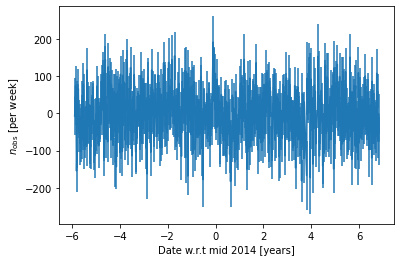

In [3]:
excess_counts = nObs_LE-nExp_LE
sigma_counts =  np.sqrt(nObs_LE)
plt.errorbar(years_since_mid_2014, excess_counts, yerr=sigma_counts)
plt.xlabel(r"Date w.r.t mid 2014 [years]")
plt.ylabel(r"$n_{\rm obs}$ [per week]")
plt.show()

# Step 1.   The model

We just write a simple function for our model, and plot how the model looks for a few values of the parameters. Call $p_0$ and $p_1$ our parameters, representing the offset and slope in a linear model, respectively. Then our model for time dependence, given these parameters, is:

$m_{\rm ex}(t | p_0, p_1) = p_0 + t * p_1$ 

In the next cell we will define a function that returns the model prediction for the y-values (i.e., excess counts) if you pass in a set of x-values (i.e., times).

In [4]:
def linear_function(xvals, params):
    return params[0] + xvals*params[1]

Now we are going to plot that model for a few different sets of paramters.

First we will change $p_0$, the offset parameter, and plot that.

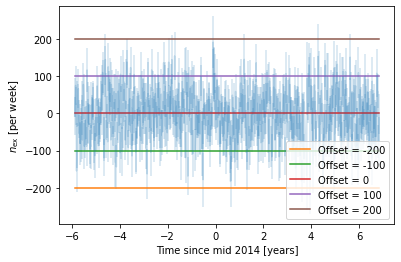

In [5]:
plt.xlabel(r"Time since mid 2014 [years]")
plt.ylabel(r"$n_{\rm ex}$ [per week]")
plt.errorbar(years_since_mid_2014, excess_counts, yerr=sigma_counts, alpha=0.2)

xvals = years_since_mid_2014
params = np.array([0, 0])
for offset in np.linspace(-200, 200, 5):
    params[0] = offset
    plt.plot(xvals, linear_function(xvals, params), label=rf"Offset = {offset:0.0f}")
plt.legend()
plt.show()

Now we will change $p_1$, the slope, and plot that.

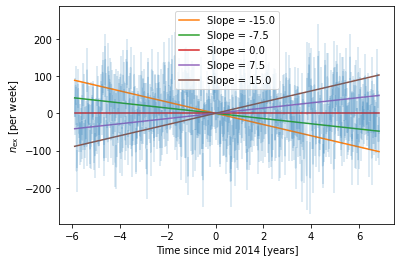

In [6]:
plt.xlabel(r"Time since mid 2014 [years]")
plt.ylabel(r"$n_{\rm ex}$ [per week]")
plt.errorbar(years_since_mid_2014, excess_counts, yerr=sigma_counts, alpha=0.2)

xvals = years_since_mid_2014
params = np.array([0, 0])
for slope in np.linspace(-15, 15, 5):
    params[1] = slope
    plt.plot(xvals, linear_function(xvals, params), label=rf"Slope = {slope:0.1f}")
plt.legend()
plt.show()

### An important distinction.

It is important not to get confused between the model, which is just saying that the number of counts changes linearly with time, and a particular version of the model with specific set of parameters.  Keep that in mind as you answer the next question, and for the rest of the notebook.

### Questions for discussion

#### 4.1  How well do you think this model describes the data?  Is this a sensible model?   What would it mean if $p_0$ were very different from 0?  What about if $p_1$ were different from zero?

# Step 2.   The residuals

Let's write a function to plot the residuals given the model parameters.  The indvidual residuals are: $\delta_i = n_{\rm ex,i} - m_{\rm ex,i} = n_{\rm ex,i} - (p_0  + t * p_1)$, or in words, the difference between the model predictions and the measured data points.

The first function 'residual_function' computes the residuals $\delta_i$ for each week.  

The second function 'plot_residuals' makes scatter plots of the residuals for different sets of model parameters versus time.

The third function 'hist_residuals' makes histograms of the residuals for different sets of model parameters over all the weeks. 

In [7]:
def residual_function(data_x, data_y, model_function, params):
    model_y = model_function(data_x, params)
    residual = data_y - model_y
    return residual

In [8]:
def plot_residuals(xvals, yvals_list):
    plt.xlabel(r"Time since mid 2014 [years]")
    plt.ylabel(r"$\delta$ [counts]")
    for yvals in yvals_list:
        plt.scatter(xvals, yvals)
    plt.show()

In [9]:
def hist_residuals(yvals_list):
    plt.xlabel(r"$\delta$ [counts]")
    plt.ylabel("Weeks [per 10 counts]")
    for yvals in yvals_list:
        plt.hist(yvals, bins=np.linspace(-300, 300, 61), histtype='step')
    plt.show()

In [10]:
resid_0_0 = residual_function(years_since_mid_2014, excess_counts, linear_function, [0,0])
resid_0_20 = residual_function(years_since_mid_2014, excess_counts, linear_function, [0,20])

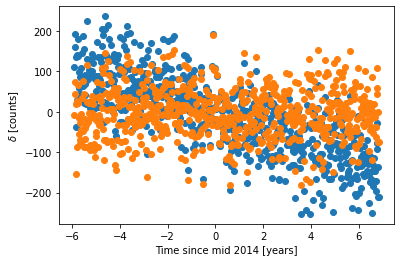

In [11]:
plot_residuals(years_since_mid_2014, [resid_0_20, resid_0_0])

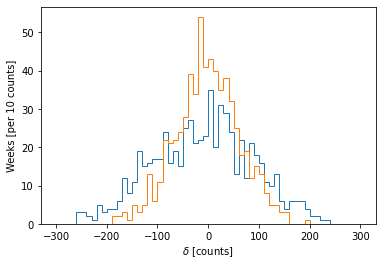

In [12]:
hist_residuals([resid_0_20, resid_0_0])

# Step 3.   The scaled residuals

Let's write a function to plot the scaled residuals (i.e.,  the residuals divided by the uncertainties on the data points to scale them down to a unit Gaussian) given the model parameters:

$\chi_i =  \frac{n_{\rm ex,i} - m_{\rm ex,i}}{\sigma_{obs, i}} = \frac{n_{\rm ex,i} - (p_0  + t_i * p_1)}{\sigma_{obs, i}}$

In [13]:
def hist_scaled_residuals(yvals_list):
    plt.xlabel(r"$\delta$ [$\sigma$]")
    plt.ylabel(r"Weeks [per $0.2 \sigma$]")
    for yvals in yvals_list:
        plt.hist(yvals, bins=np.linspace(-5, 5, 51), histtype='step')
    plt.show()

#### Here we scale the individual residuals, so that we can make nice scatter plots of the scaled residuals.

In [14]:
chi_0_0 = resid_0_0/sigma_counts
chi_0_20 = resid_0_20/sigma_counts

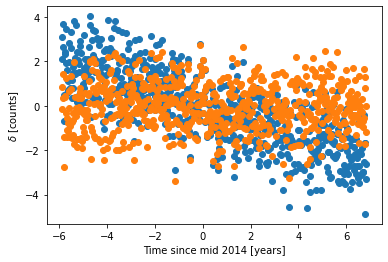

In [15]:
plot_residuals(years_since_mid_2014, [chi_0_20, chi_0_0])

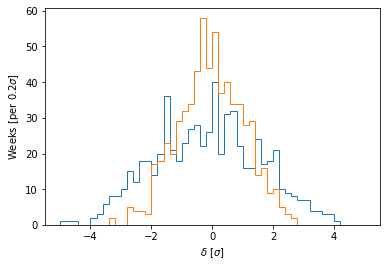

In [18]:
hist_scaled_residuals([chi_0_20, chi_0_0])

###  Questions for discussion.

#### 5.1 Using what we learned last week about Gaussian distributions and p-values, explain why the two plots with the scaled residuals are much more useful than the two plots with the unscaled residuals.

#### 5.2 Given the plot above, do you think that there is any chance that the true value of $p_1$ is actually 20 counts / year?  Explain why or why not.

# Step 4.   The $\chi^2$

Let's write a function to compute the $\chi^2$ given the model parameters:  $\chi^2 = \sum_i \chi_i^2$.

For ideal data, where the residuals are assumed to be drawn from a gaussian distribution centered at zero, the expected distribution of $\chi^2$ is known (and given by the scipy.stats.chi2 function). The form of this distribution is dependent on a quantity called the "degrees of freedom" (also called $DOF$ or $d_{f}$ in shorthand), which for N data points and M fit parameters is given by:

$DOF = N - M$

For a "good" fit, the $\chi^2/DOF$ should approximately equal 1.

In [19]:
def chi2_function(data_x, data_y, data_sigma_y, model_function, params):
    model_y = model_function(data_x, params)
    chi2 = ((data_y - model_y)/(data_sigma_y))**2
    return np.sum(chi2)

In [20]:
chi2_0_0 = chi2_function(years_since_mid_2014, excess_counts, sigma_counts, linear_function, [0,0])
chi2_0_20 = chi2_function(years_since_mid_2014, excess_counts, sigma_counts, linear_function, [0,20])
chi2_check = np.sum(chi_0_0*chi_0_0)
print(f"chi**2(0,0)  : {chi2_0_0:0.1f}")
print(f"chi**2 check : {chi2_check:0.1f}")
print(f"chi**2(0,20) : {chi2_0_20:0.1f}")

chi**2(0,0)  : 765.2
chi**2 check : 765.2
chi**2(0,20) : 1941.2


In [21]:
print(f"The odds of seeing the observed data given params (0.,0.) are {stats.chi2(df=chi_0_0.size-2).sf(chi2_0_0):.1e}")
print(f"The odds of seeing the observed data given params (0.,20.) are {stats.chi2(df=chi_0_20.size-2).sf(chi2_0_20):.1e}")

The odds of seeing the observed data given params (0.,0.) are 1.1e-03
The odds of seeing the observed data given params (0.,20.) are 7.0e-129


### Question for discussion.

#### 6.1 We just saw that in an idealized case, chance of seeing the observed data given model parameters (0.,20.) is astonishingly less likely (by a factor of $10^{126}$ than the change of seeing the observed data if the model parameters were (0., 0.).  Explain why this is, using information from the plots above question 5.2.

# Step 5.  Minimizing the $\chi^2$

Ok, first we are going to try find the set of parameters that given us the best $\chi^2$ value.  

We have constructed the $\chi^2$ by summing together in quadrature a bunch of quantities that, in an ideal world, are each distributed as a Unit Gaussian.  This gives us a really powerful tool to interpret changes in the $\chi^2$ value in terms of Gaussian errors. 

If we are varying a single parameter, we can interpert changes in the parameter that result in a 1 unit change of $\chi^2$ as the $1 \sigma$ uncertainty on that parameter.  In general, if $\hat{p}$ is the parameter values that minimize the $\chi^2$, then we can solve for the uncertainty $\sigma_p$ using the relationship: 

$\Delta \chi^2 = \chi^2(\hat{p} + n \sigma_p) - \chi^2(\hat{p}) = n^2$

Where we can pick $n$ to be some convienient number, e.g., 1 in our case.

This means that we want to calculate both a curve for $\chi^2$ as a function of the parameters of interest.  I.e., $\chi^2(p)$.  

(Note that $\chi^2$ also depends on the data points, and the errors on the data points, but we left that out of the equation to focus on the fact that we are just changing the model parameters and trying to match the data).

# scanning parameters.

We are first going to find the parameter values that minimize the $\chi^2$ by scanning each of the parameters and computing the resulting $\chi^2$. 

First we are going to scan each variable on it's own.  Then we will do a two dimensional scan.

We will do $p_0$ (the offset parameter) first.  We will scan from -5 to 5 counts in 11 steps.

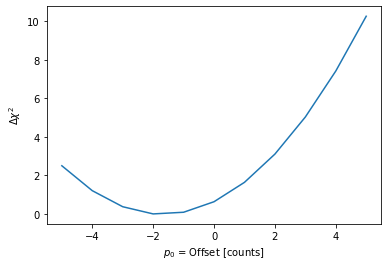

In [22]:
plt.xlabel(r"$p_0$ = Offset [counts]")
plt.ylabel(r"$\Delta \chi^2$")

params = np.array([0., 0.])
chi2_vals = np.zeros((11))
offset_scan_points = np.linspace(-5., 5., 11)
for i in range(11):
    params[0] = offset_scan_points[i]
    chi2_vals[i] = chi2_function(years_since_mid_2014, excess_counts, sigma_counts, linear_function, params)

chi2_vals -= chi2_vals.min()
plt.plot(offset_scan_points, chi2_vals)
plt.show()

Ok, now let's scan the slope parameter, $p_1$.  We will scan from -2 to 2 counts / year in 11 steps.

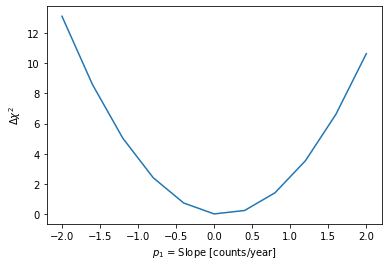

In [23]:
plt.xlabel(r"$p_{1}$ = Slope [counts/year]")
plt.ylabel(r"$\Delta\chi^2$")

params = np.array([0., 0.])
chi2_vals = np.zeros((11))
slope_scan_points = np.linspace(-2., 2., 11)
for i in range(11):
    params[1] = slope_scan_points[i]
    chi2_vals[i] = chi2_function(years_since_mid_2014, excess_counts, sigma_counts, linear_function, params)

chi2_vals -= chi2_vals.min()
plt.plot(slope_scan_points, chi2_vals)
plt.show()

### Quick Question

#### 7.1 Estimate numerical values for the best-fit values and 1 $\sigma$ uncertainties on $p_0$ and $p_1$ using the two plots above.

### Extracting multiple parameters at once.

Now we are going to extract best-fit values for both $p_0$ and $p_1$ by evaluting the $\chi^2$ function over points on a two dimensional grid.

We plot the result as a color plot, where the color is the $\Delta \chi^2$ value, and we are going to draw some contours on the plot correspond to different levels of $\Delta \chi^2$.

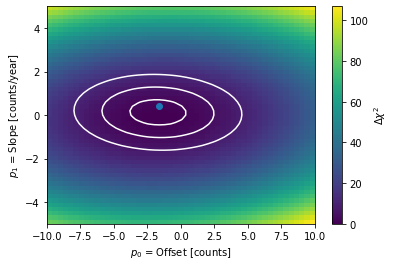

Best fit value is 764.5 for (-1.6 0.4)


In [24]:
plt.xlabel(r"$p_0$ = Offset [counts]")
plt.ylabel(r"$p_1$ = Slope [counts/year]")


nx = 51
ny = 51

params = np.array([0., 0.])
chi2_2d_scan_vals = np.zeros((nx, ny))
offset_scan_points = np.linspace(-10, 10, nx)
slope_scan_points = np.linspace(-5, 5, ny)

# Double loop for 2d scan
for i in range(nx):
    params[0] = offset_scan_points[i]
    for j in range(ny):
        params[1] = slope_scan_points[j]
        chi2_2d_scan_vals[i,j] = chi2_function(years_since_mid_2014, excess_counts, sigma_counts,
                                               linear_function, params)

min_chi2 = chi2_2d_scan_vals.min()
chi2_2d_scan_vals -= min_chi2

# This next bit gets the x and y axis values for the grid point at the minimum.
idx = chi2_2d_scan_vals.argmin()
idx_x = idx//nx
idx_y = idx%ny
scan_min_x = offset_scan_points[idx_x]
scan_min_y = offset_scan_points[idx_y]

# Now let's plot it.
plt.imshow(chi2_2d_scan_vals.T, extent=(-10, 10, -5, 5), aspect='auto')
plt.colorbar(label=r"$\Delta \chi^2$")
plt.contour(offset_scan_points, slope_scan_points, chi2_2d_scan_vals.T, levels=[1, 4, 9], colors="white")
plt.scatter(scan_min_x, scan_min_y)
plt.show()

print(f"Best fit value is {min_chi2:0.1f} for ({scan_min_x:0.1f} {scan_min_y:0.1f})")

# Step 6, statistical significance of fit values

By scanning with a finer grid, we can get a smoother curve and find a value of 0.13 +- 0.58 for $p_1$, the slope of the model line.

Similarly to what we did last week, we can use `scipy.stats.norm` to compute the p-value.  Once slight difference is that this time we are considering both positive and negative values, so we integrate the Gaussian outward starting from the middle, using the formula in the cell below.

In [25]:
def two_sided_p_chi2(x, mu, sigma):
    return 2*(stats.norm(loc=mu, scale=sigma).sf(np.abs(x)))

In [26]:
p_val = two_sided_p_chi2(0.13, 0, 0.58)
print(f"The p-value to obtain a measurement of {0.13:0.2f} given a true value of {0:0.2f} and a sigma of {0.58:0.2f} is {p_val:0.2f}")

The p-value to obtain a measurement of 0.13 given a true value of 0.00 and a sigma of 0.58 is 0.82


### Quick question.

#### 8.1  Is this result statistically significant?  I.e., should we write a paper saying that Vela is getting dimmer?  Why or why not?

# Summary of this notebook

So, to investigate if the correlation was significant we did a few things:

1. A **model** with **parameters** to describe the data.  In our case we fit the excess as a function of time to a line,  i.e., $m_{\rm ex}(t | p_0, p_1) = p_0 + t * p_1$ 

2. A function to compute how close the model is to each data point.   I.e., how well the model fits the data.  To do this we will first compute the **residuals** for each data point: $\delta_i = n_{\rm ex,i} - m_{\rm ex,i} = n_{\rm ex,i} - (p_0  + t * p_1)$ 

3. To interpret the residuals we **scaled** them by their errors, in this case that is the error bars in the plot above, which are just the square root of the number of observed counts, let's call these $\sigma_i = \sqrt{n_{obs, i}}$,  Then we have  $\chi_i =  \frac{n_{\rm ex,i} - m_{\rm ex,i}}{\sigma_{obs, i}} = \frac{n_{\rm ex,i} - (p_0  + t_i * p_1)}{\sigma_{obs, i}}$   At that point, if the model were perfect the scaled residuals $\chi_i$ should each be a variable sampled from a unit Gaussian, i.e., $G(\chi_i | \mu=0, \sigma=1)$.

4. The next step was to **test** how well the model fits the data.  Since we have a bunch of data points that ideally should be represented by Gaussians, we can add the variances in quadrature to get a meaningful quantity.  $\chi^2 = \sum_i \chi_i^2 = \sum_i (\frac{n_{\rm ex,i} - (p_0  + t_i * p_1)}{\sigma_{obs, i}})^2$.   The $\chi^2$ tells us how well the model fits the data, on average we expect each data point to contribute about 1 unit to the total $\chi^2$ (because each point is coming from a unit Gaussian).   Lower $\chi^2$ represent better fits.

5. We varied the input parameters $(p_0, p_1)$ to find the values that **minimize** the $\chi^2$.

6. Finally, compared the change in $\chi^2$ between the best fit model and other parameter values and use this to intepret the statistical significance.

